In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [2]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
from graphlearn.graphlearn import GraphLearnSampler
from eden.util import fit,predict
from eden.graph import Vectorizer
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [3]:
def fit_sample(graphs):
    graphs, graphs_ = tee(graphs)
    sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],
                              min_cip_count=2, min_interface_count=2,
                              vectorizer=Vectorizer(5))
    
    sampler.fit(graphs, nu=0.3, n_jobs=-1)

    print('graph grammar stats:')
    interface_counts, core_counts, cip_counts = sampler.grammar().size()
    print('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))
    graphs = sampler.sample(graphs_,
                            n_steps=8, n_samples=6,
                            target_orig_cip=True,
                            probabilistic_core_choice=False,
                            score_core_choice= True,
                            max_core_size_diff=0,
                            improving_threshold=0.5, accept_static_penalty=0,
                            n_jobs=-1,burnin=1,select_cip_max_tries=200,keep_duplicates=True)
    return graphs

In [4]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_augmented, neg_augmented,
                     local_estimator):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_augmented , pos_sampled = tee(pos_augmented)
    neg_augmented , neg_sampled = tee(neg_augmented)
    
    pos_augmented = chain(pos_augmented,pos_orig_)
    neg_augmented = chain(neg_augmented,neg_orig_)

    outputs = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        if pos_size == 0 or neg_size == 0:
            print "-"*80
            print 'working on %s'%(desc)
            print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
            print 'WARNING: empty dataset'
            outputs.append(0)
        else:
            start=time()
            print "-"*80
            print 'working on %s'%(desc)
            print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
            margins = predict(pos_train, 
                              estimator=local_estimator, 
                              vectorizer=Vectorizer(4), 
                              mode='predict_proba',
                              n_jobs=-1)
            avg_score=np.mean(margins)
            print 'avg margin for positives: %.3f' % avg_score
            outputs.append(avg_score)
            print 'elapsed: %.1f sec'%(time()-start)
    return outputs

In [5]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            from sklearn.linear_model import SGDClassifier
            estimator=SGDClassifier(average=True, class_weight='auto', shuffle=True, loss='log', n_jobs=-1)
            local_estimator = fit(pos_test_global_, neg_test_global_, Vectorizer(4), estimator, n_jobs=-1, n_iter_search=1)
           
            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            print('Positive')
            sampled_pos = fit_sample(pos)
            print('Negative')
            sampled_neg = fit_sample(neg)

            #evaluate the predictive performance on held out test set
            start=time()
            print "="*80
            print 'repetition: %d/%d'%(repetition+1, n_repetitions)
            print "training percentage:"+str(percentage)
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos_,neg_,
                                              sampled_pos,sampled_neg,
                                              local_estimator)
            print 'Time elapsed: %.1f sec'%((time()-start))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

In [6]:
%%time
#experiment

dataset_names = !cat NCI60/names
dataset = dataset_names[6]
print 'Working with dataset: %s' % dataset 
pos_dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
neg_dataset_fname = 'NCI60/' + dataset + '_orig_neg.gspan'

#pos_dataset_fname = 'bursi.pos.gspan'
#neg_dataset_fname = 'bursi.neg.gspan'


percentages=[.2,.4,.6,.8]
original_repetitions,\
original_sample_repetitions,\
sample_repetitions = evaluate(pos_dataset_fname,neg_dataset_fname,
                              size=400,
                              percentages=percentages,
                              n_repetitions=2,
                              train_test_split=0.7)

Working with dataset: IGROV1_t
Positive
graph grammar stats:
#interfaces: 51   #cores: 54   #core-interface-pairs: 219
Negative
graph grammar stats:
#interfaces: 41   #cores: 52   #core-interface-pairs: 159
repetition: 1/2
training percentage:0.2
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 56 #neg: 56
avg margin for positives: 0.500
elapsed: 1.0 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #pos: 56 #neg: 56
avg margin for positives: 0.500
elapsed: 3.3 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 112 #neg: 112
avg margin for positives: 0.500
elapsed: 3.4 sec
Time elapsed: 43.3 sec
Positive
graph grammar stats:
#interfaces: 51   #cores: 54   #core-interface-pairs: 219
Negative
graph grammar stats:
#interfaces: 41   #cores: 52   #core-inte

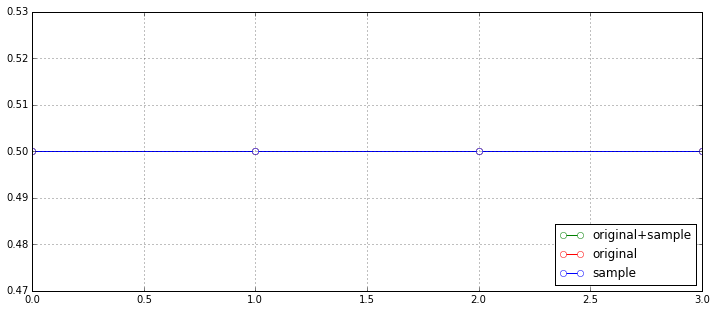

In [7]:
# plot
os = np.mean(original_sample_repetitions, axis=1)
o = np.mean(original_repetitions, axis=1)
s = np.mean(sample_repetitions, axis=1)
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(os, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='original+sample')
plt.plot(o, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original')
plt.plot(s, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('%s_plot_probability_of_samples.pdf' % dataset)

/Users/costa/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


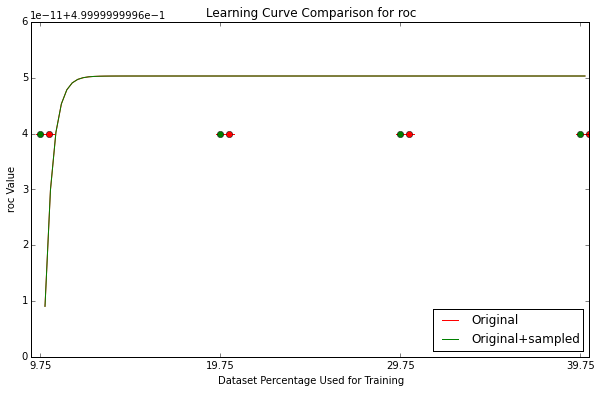

In [8]:
# plot
from graphlearn.utils.draw import draw_learning_curve
draw_learning_curve(data_first=original_repetitions,
                    data_second=original_sample_repetitions,
                    x_axis=percentages,
                    measure='roc',
                    delta=0.005,scaling=50)

.